In [17]:
import os
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [18]:
CLASS_NAMES = ['cry', 'scream', 'norm']
SAMPLE_RATE = 16000
data_dir = 'C:/Users/AarushiGarg/Desktop/crying/data'

In [19]:
def load_audio_files():
    data = []
    labels = []
    for label in CLASS_NAMES:
        folder = os.path.join(data_dir, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                path = os.path.join(folder, file)
                signal, sr = librosa.load(path, sr=SAMPLE_RATE)
                data.append(signal)
                labels.append(CLASS_NAMES.index(label))
    return np.array(data, dtype=object), np.array(labels)


In [20]:
X, y = load_audio_files()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [22]:
def predict_yamnet(audio):
    waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return tf.reduce_mean(scores, axis=0).numpy()

In [23]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec2_model = Wav2Vec2ForSequenceClassification.from_pretrained("superb/wav2vec2-base-superb-ks")

C:\Users\AarushiGarg\Desktop\crying\infant_audio_env\lib\site-packages\transformers\configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [26]:
def predict_wav2vec(audio):
    input_values = feature_extractor(audio, sampling_rate=SAMPLE_RATE, return_tensors="pt").input_values
    with torch.no_grad():
        logits = wav2vec2_model(input_values).logits
    return torch.nn.functional.softmax(logits, dim=-1).numpy()[0]

In [27]:
def ensemble_predict(audio):
    yamnet_probs = predict_yamnet(audio)
    wav2vec_probs = predict_wav2vec(audio)
    combined_probs = (yamnet_probs[:3] + wav2vec_probs[:3]) / 2  # Only top 3 for simplicity
    return np.argmax(combined_probs)

In [28]:
predictions = [ensemble_predict(x) for x in X_test]
print(classification_report(y_test, predictions, target_names=CLASS_NAMES))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

         cry       0.35      0.70      0.47        10
      scream       0.00      0.00      0.00        17
        norm       0.42      0.62      0.50        13

    accuracy                           0.38        40
   macro avg       0.26      0.44      0.32        40
weighted avg       0.22      0.38      0.28        40

[[7 0 3]
 [9 0 8]
 [4 1 8]]


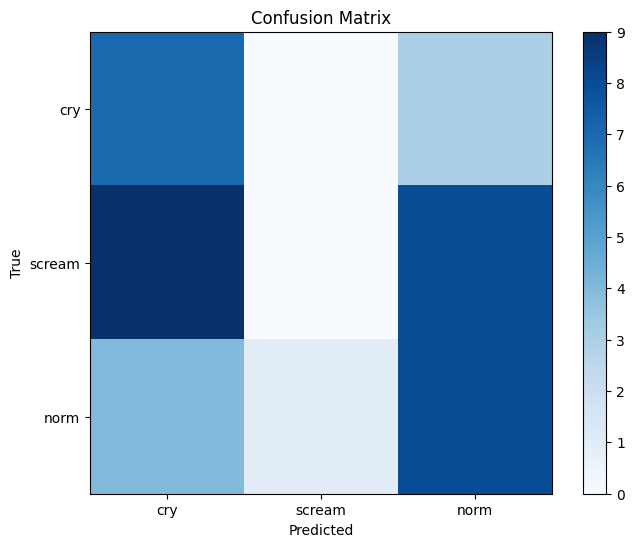

In [29]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
plt.imshow(confusion_matrix(y_test, predictions), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES)
plt.yticks(ticks=range(len(CLASS_NAMES)), labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [30]:
import os
from sklearn.utils import class_weight
import numpy as np

dataset_path = 'C:/Users/AarushiGarg/Desktop/crying/data'

y_train = []
for label in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label)
    if os.path.isdir(label_path):
        files = os.listdir(label_path)
        y_train.extend([label] * len(files))  

y_train = np.array(y_train)

In [31]:
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

print("Class distribution:", dict(zip(classes, [list(y_train).count(c) for c in classes])))
print("Class weights:", class_weights)

Class distribution: {np.str_('cry'): 63, np.str_('norm'): 68, np.str_('scream'): 72}
Class weights: {np.str_('cry'): np.float64(1.0740740740740742), np.str_('norm'): np.float64(0.9950980392156863), np.str_('scream'): np.float64(0.9398148148148148)}
